Results for year: 2020
MSE: 80.2582474708171
RMSE: 8.958696750689638
MAE: 4.010194552529183
R2 Score: 0.7190003755583442
Average Daily Cases for 2020: 14.86
 1) pcr_tests                      0.314218
 2) total_cases                    0.295034
 3) cases_diff                     0.206252
 4) hospitalised                   0.086232
 5) home_gatherings                0.058569
 6) temp_celc                      0.038796
 7) icu                            0.000569
 8) deaths                         0.000237
 9) outdoor_gatherings             0.000054
10) daily_deaths                   0.000038
11) vent                           0.000000
12) masks_mandate                  0.000000
13) schools_closed                 0.000000
14) lockdown_level                 0.000000
15) total_doses                    0.000000
16) daily_doses                    0.000000
17) restaurants_closed             0.000000
18) international_travel           0.000000


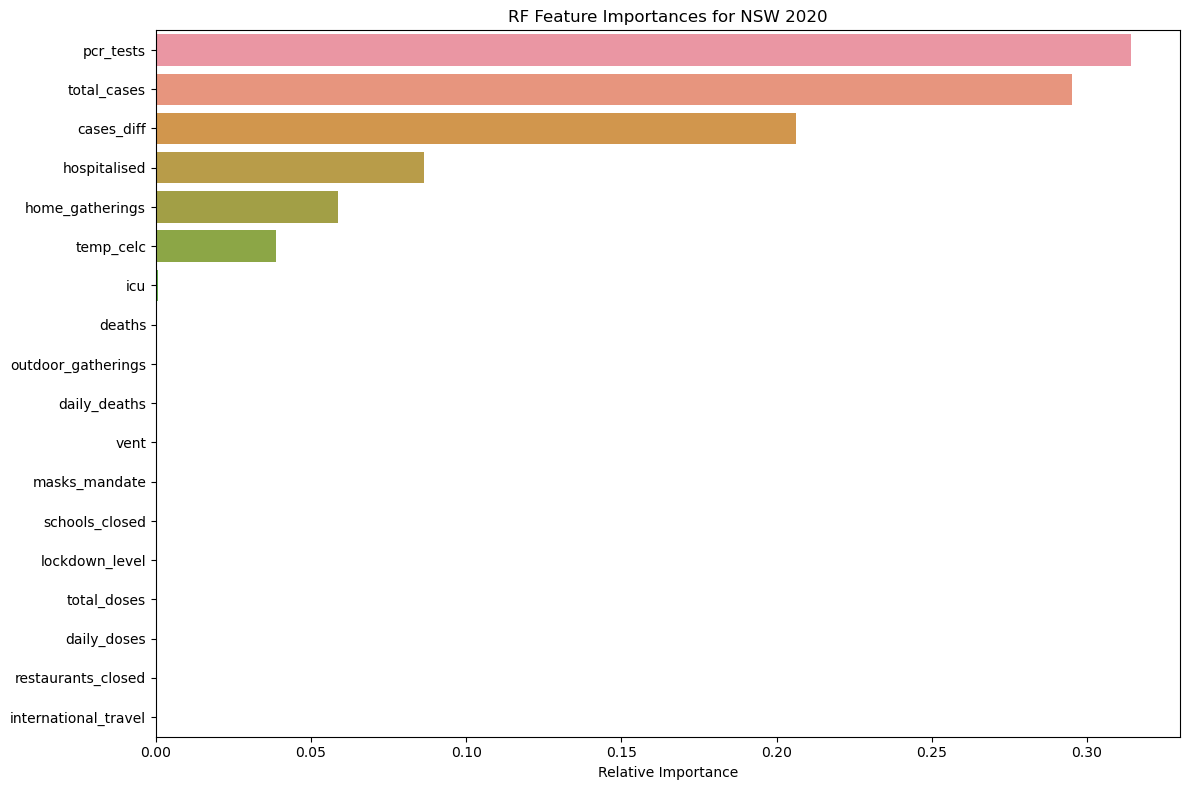

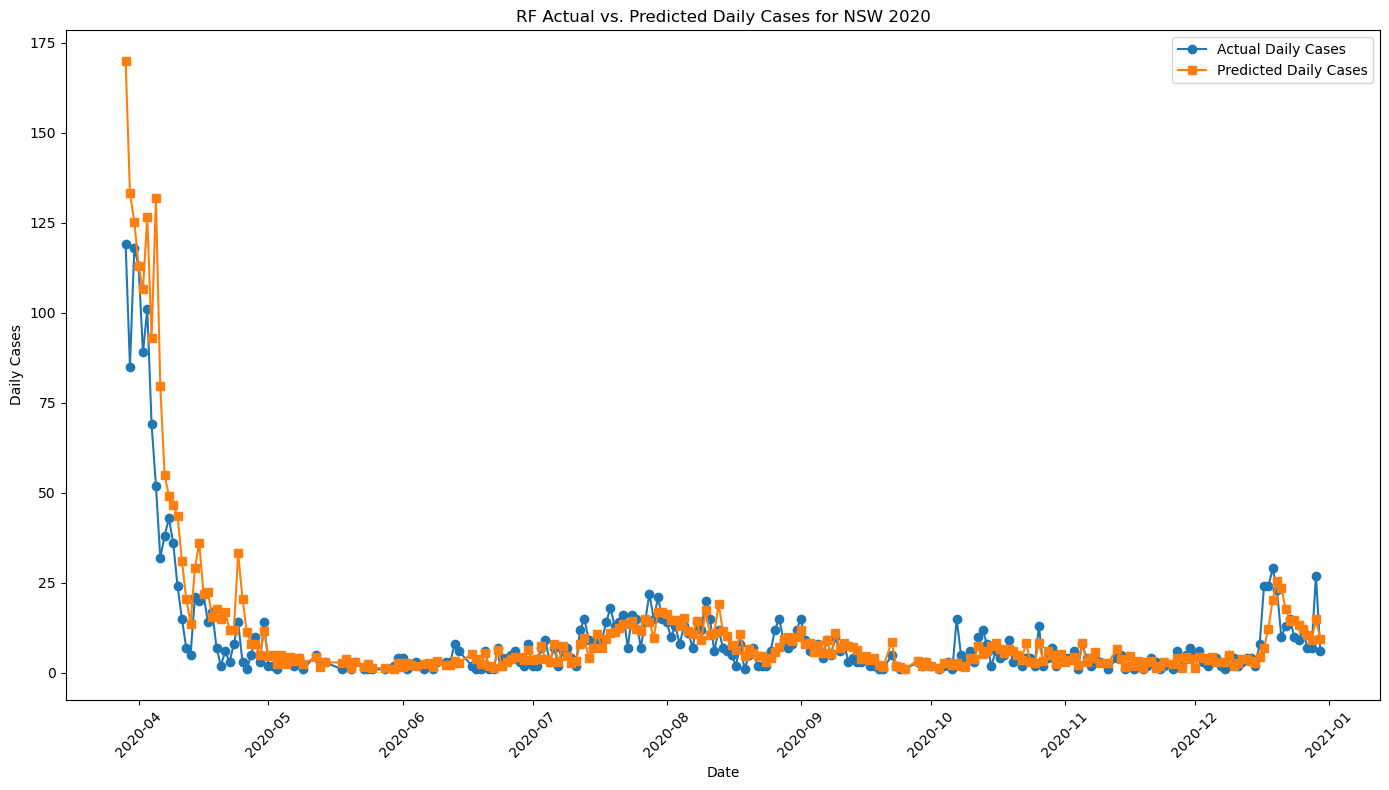

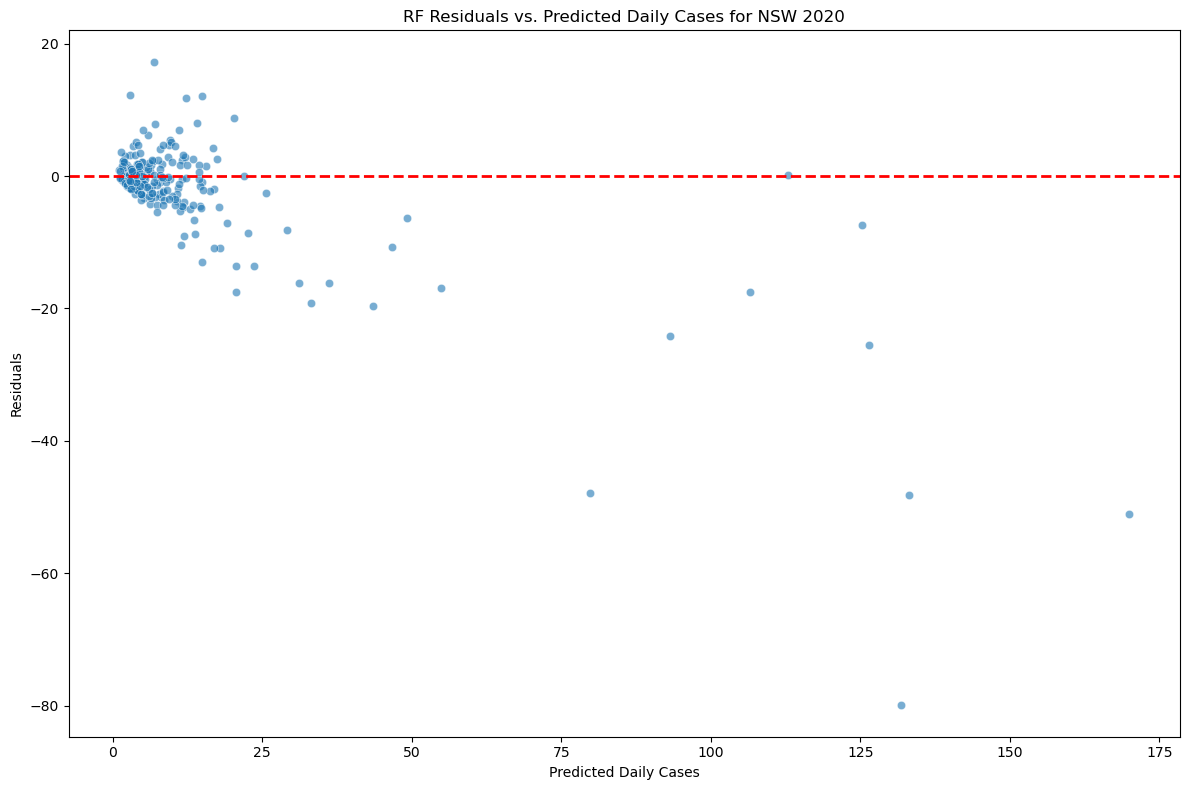

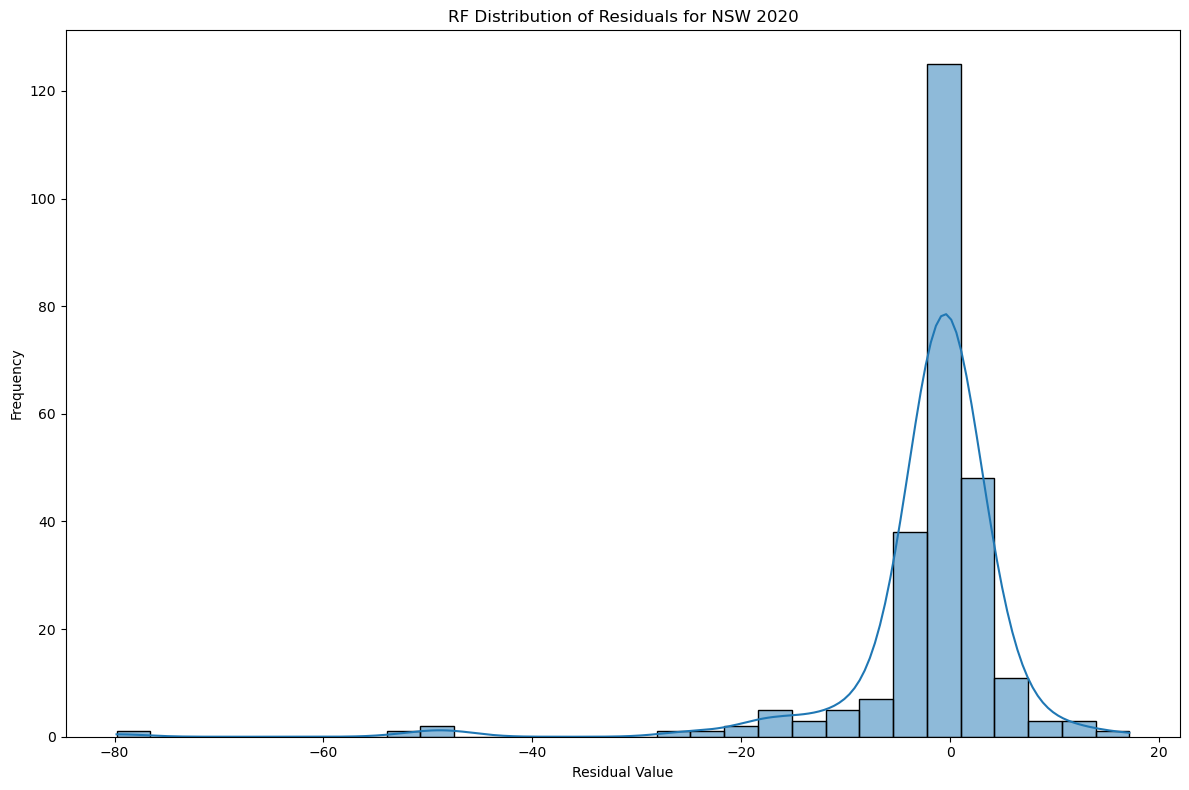

Results for year: 2021
MSE: 530073.189583165
RMSE: 728.0612540048845
MAE: 143.85084175084177
R2 Score: 0.8562331491198568
Average Daily Cases for 2021: 628.41
 1) deaths                         0.175462
 2) total_doses                    0.149761
 3) pcr_tests                      0.131337
 4) total_cases                    0.125609
 5) hospitalised                   0.123179
 6) icu                            0.122330
 7) vent                           0.112395
 8) cases_diff                     0.048482
 9) daily_doses                    0.004774
10) temp_celc                      0.003770
11) daily_deaths                   0.002900
12) masks_mandate                  0.000000
13) schools_closed                 0.000000
14) lockdown_level                 0.000000
15) restaurants_closed             0.000000
16) home_gatherings                0.000000
17) outdoor_gatherings             0.000000
18) international_travel           0.000000


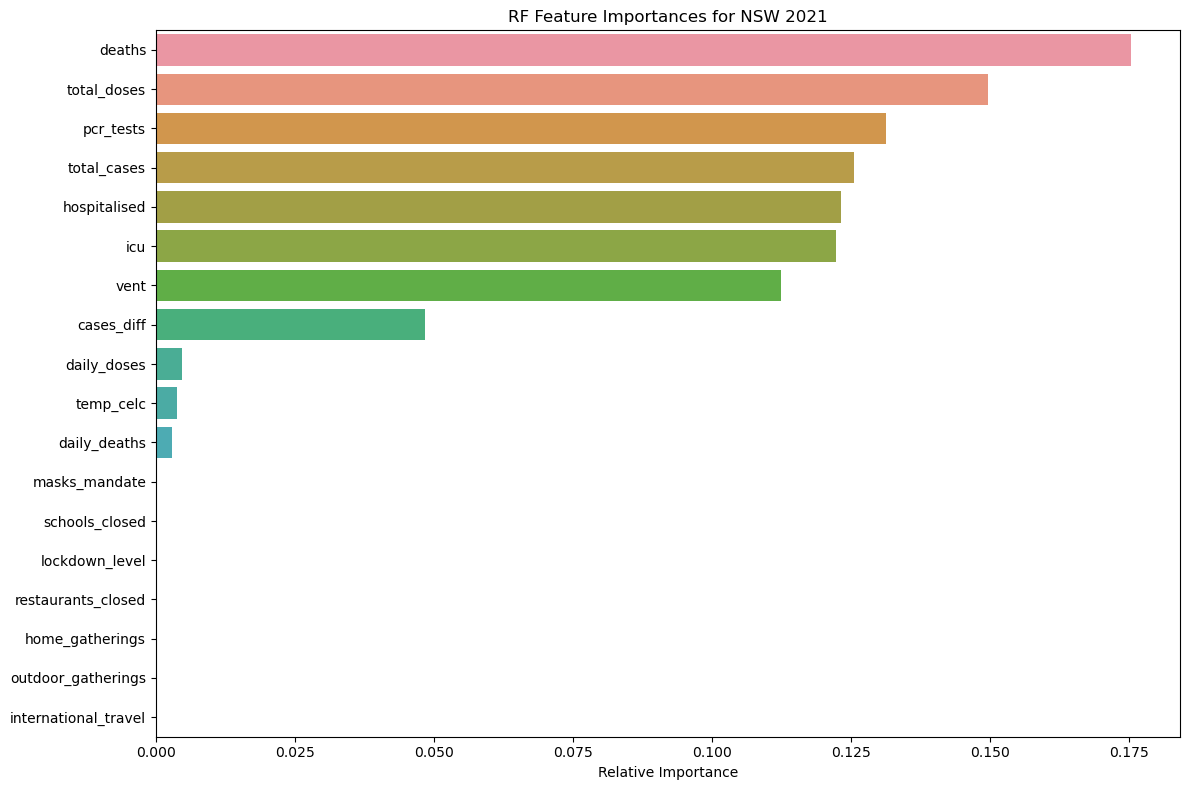

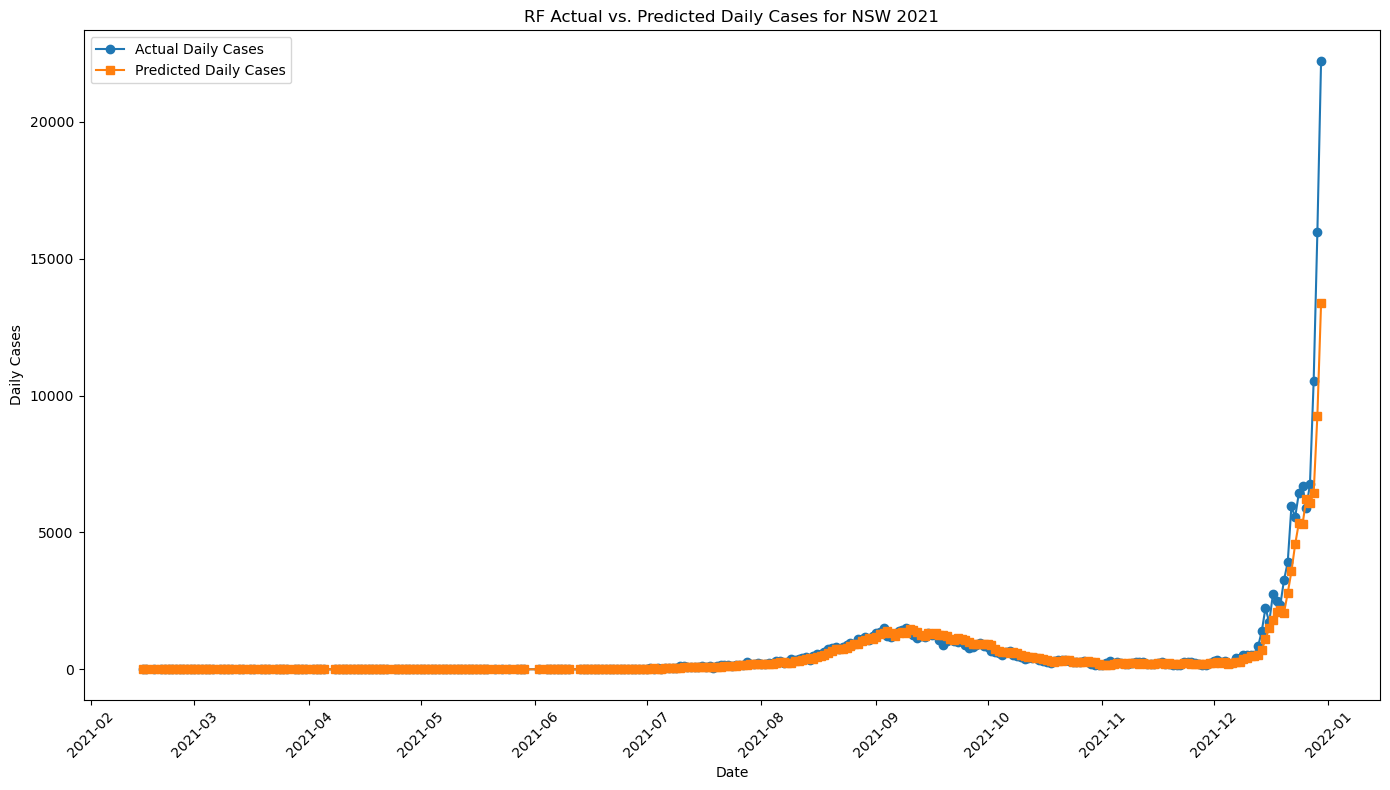

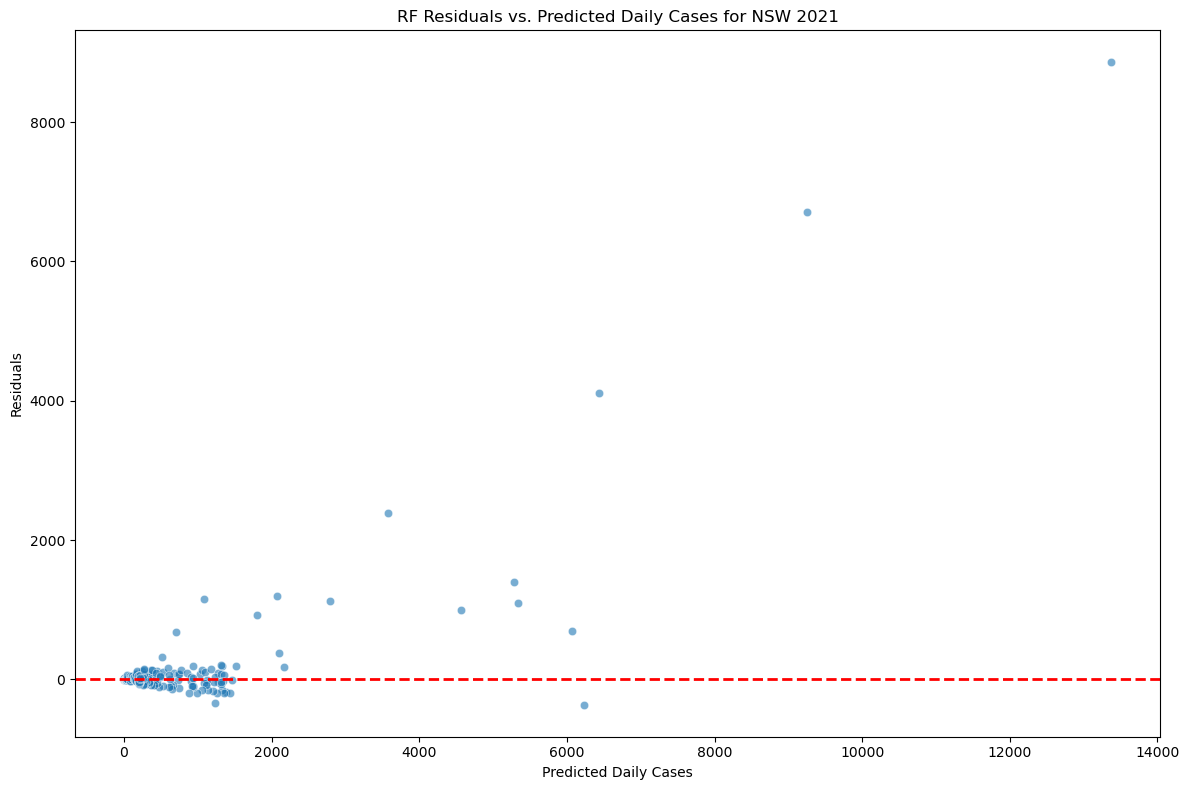

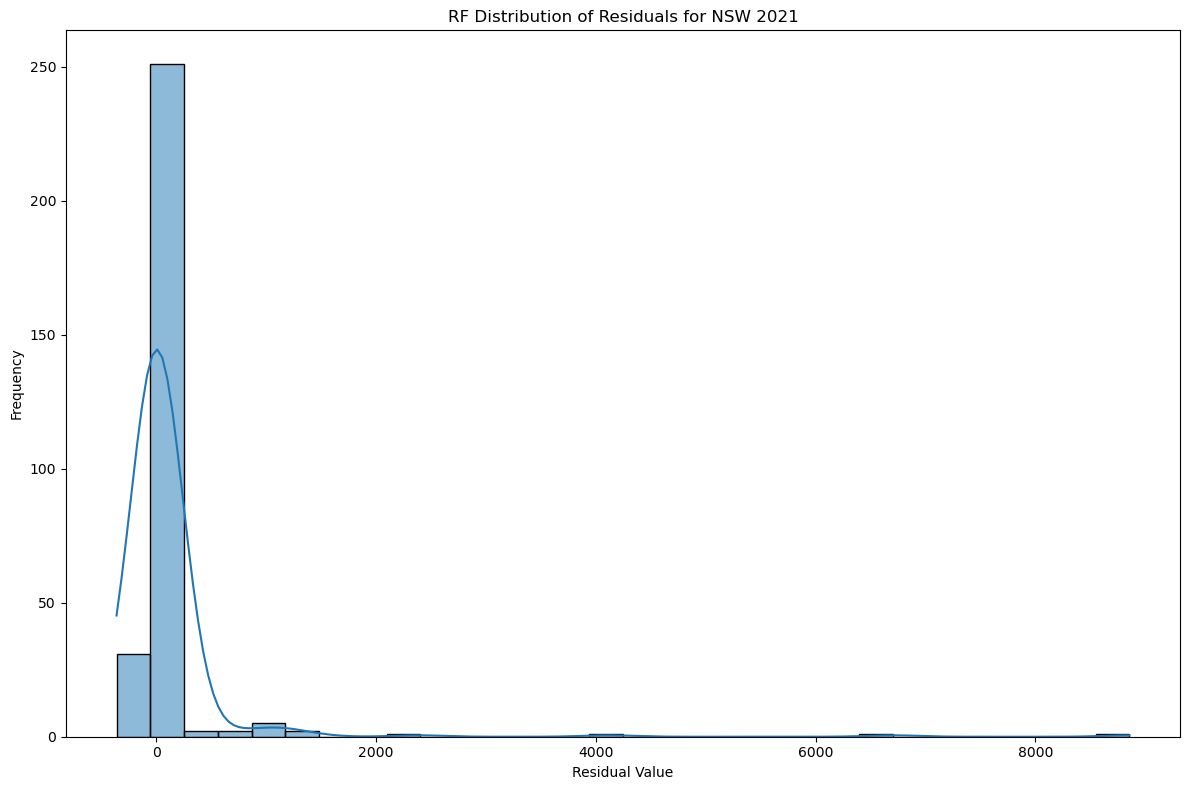

Results for year: 2022
MSE: 3552731.5854568854
RMSE: 1884.869116266932
MAE: 1308.4532934131737
R2 Score: 0.8778910248661213
Average Daily Cases for 2022: 9328.07
 1) cases_diff                     0.299502
 2) deaths                         0.115475
 3) temp_celc                      0.109765
 4) pcr_tests                      0.098269
 5) hospitalised                   0.087500
 6) total_cases                    0.084024
 7) daily_doses                    0.062401
 8) total_doses                    0.052600
 9) vent                           0.049687
10) icu                            0.034013
11) daily_deaths                   0.006764
12) masks_mandate                  0.000000
13) schools_closed                 0.000000
14) lockdown_level                 0.000000
15) restaurants_closed             0.000000
16) home_gatherings                0.000000
17) outdoor_gatherings             0.000000
18) international_travel           0.000000


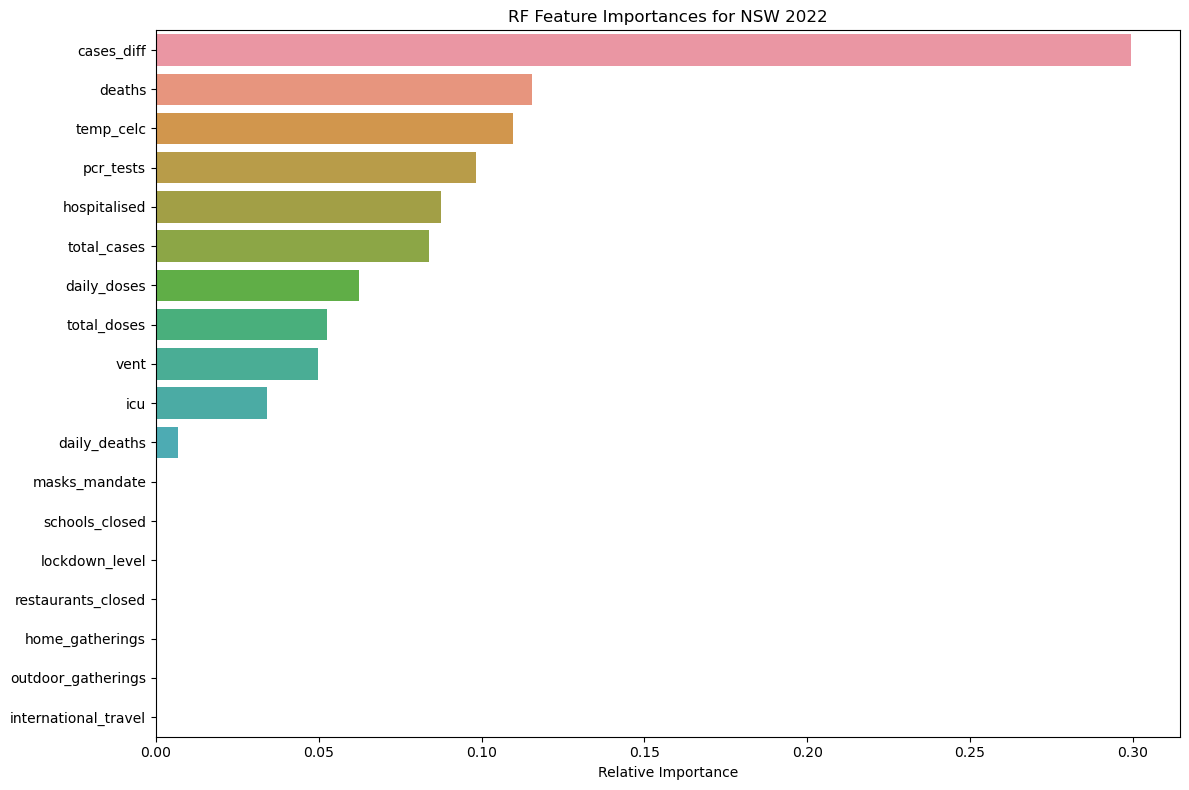

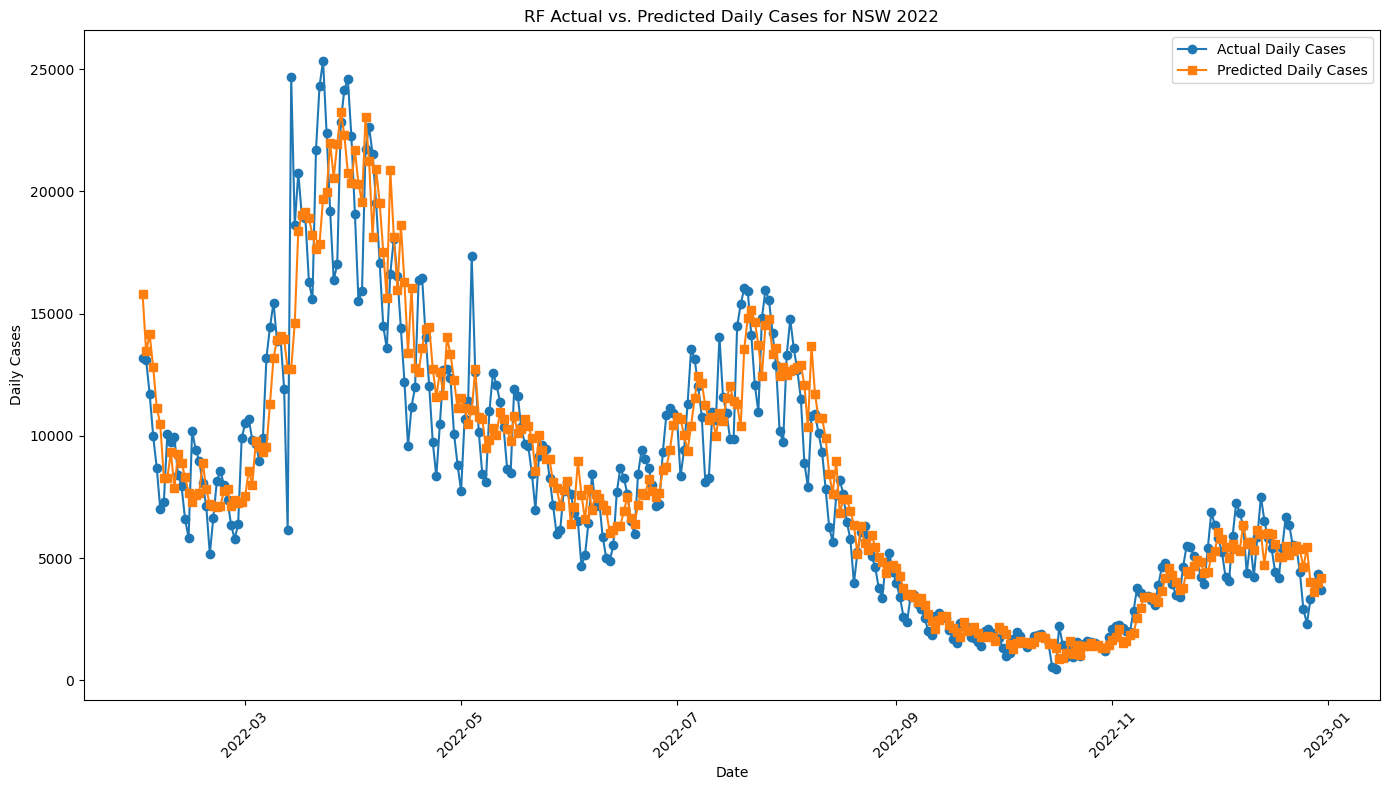

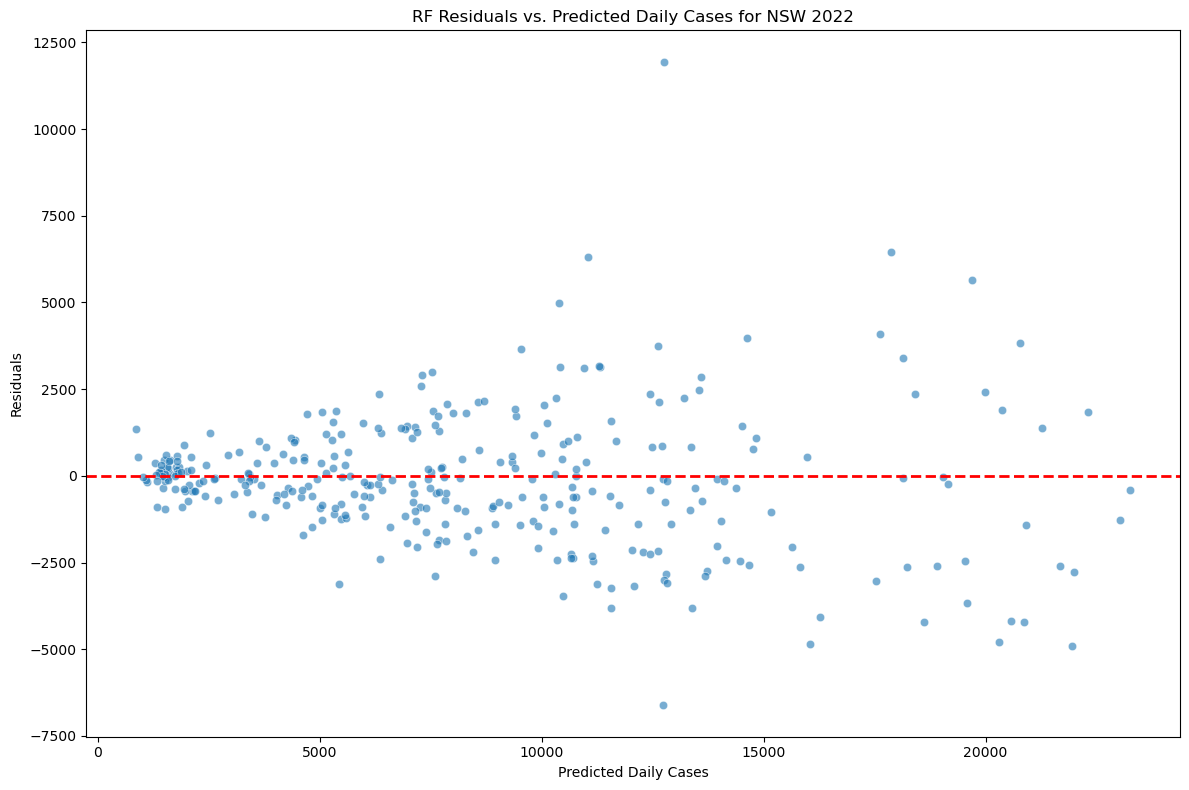

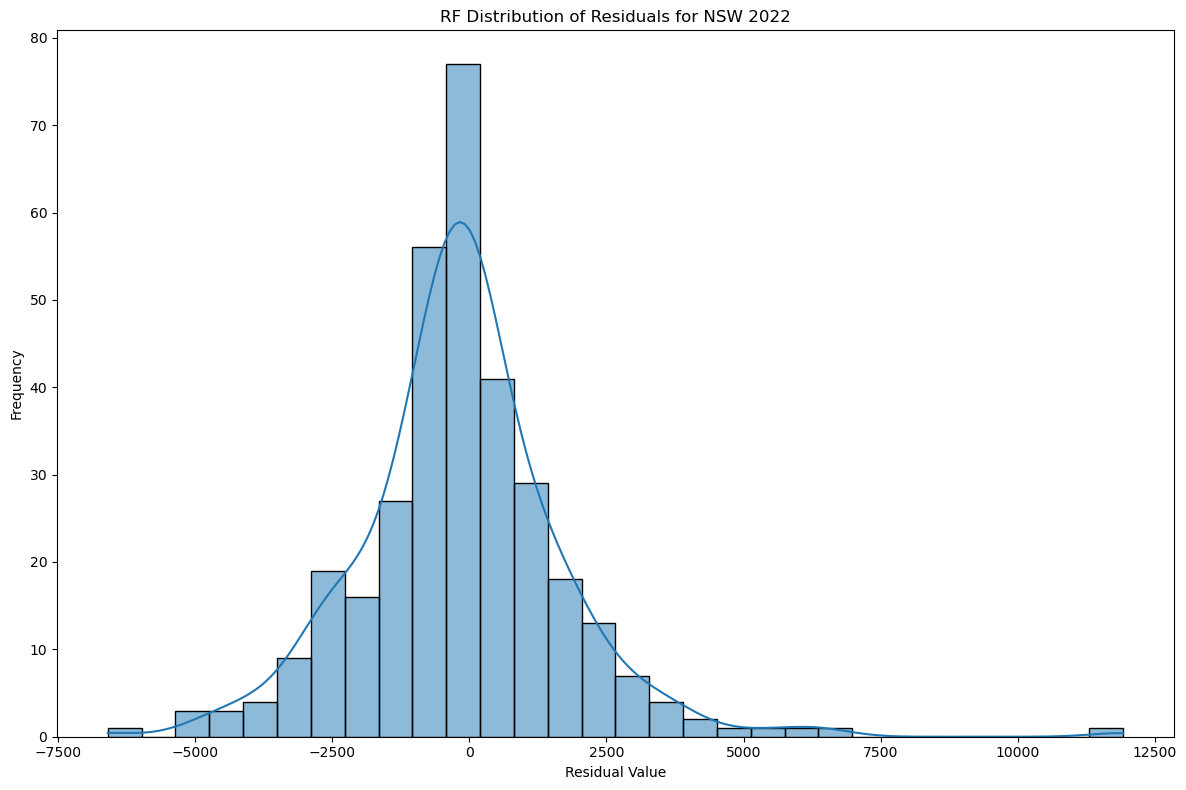

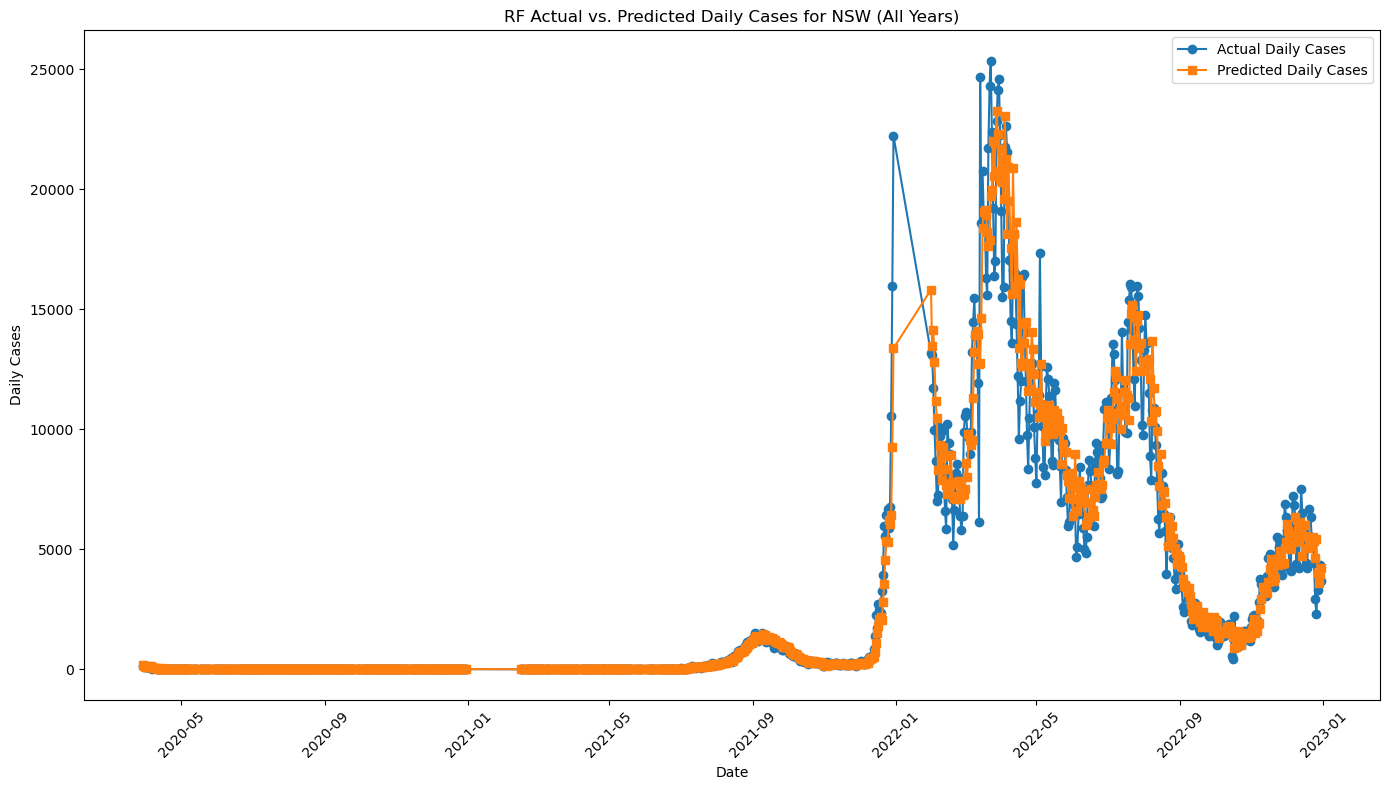

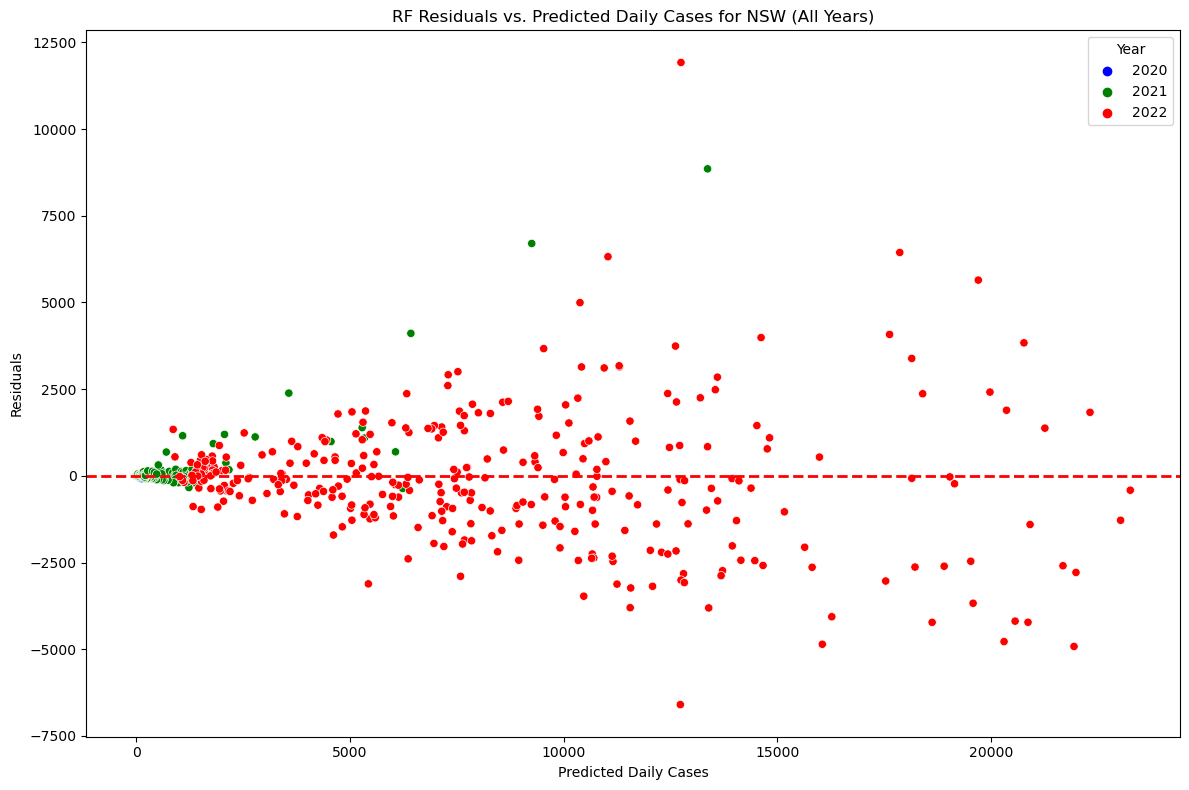

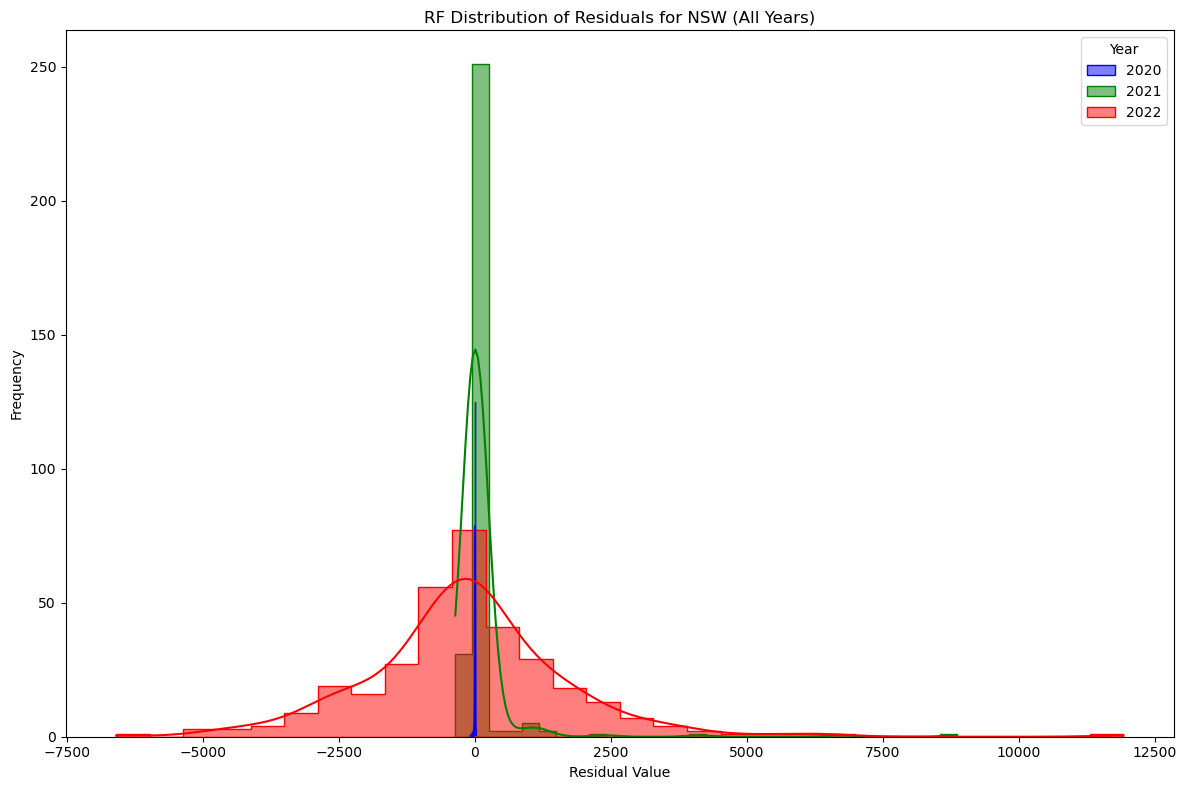

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load Data
df = pd.read_csv("nswdata.csv")

# Convert date format for model
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by='date')

# Define features
features = [
    "cases_diff", "total_cases", "daily_doses", "total_doses", "lockdown_level",
    "hospitalised", "icu", "vent", "daily_deaths", "deaths", "pcr_tests", "temp_celc",
    "schools_closed", "restaurants_closed", "home_gatherings", "outdoor_gatherings",
    "masks_mandate", "international_travel"
]

# Create arrays to store results for all years
all_y_test = []
all_y_pred = []
all_years = []
all_test_dates = []

# Set window size to 30 
window_size = 30

for year in [2020, 2021, 2022]:
    print(f"Results for year: {year}")
    df_year = df[df['date'].dt.year == year]

    X = df_year[features]
    y = df_year["daily_cases"]

    yearly_y_test = []
    yearly_y_pred = []

    # Sliding Window Loop
    for start in range(0, len(df_year) - window_size - 1):
        train = df_year[start:start + window_size]
        test = df_year[start + window_size:start + window_size + 1]
        
        X_train = train[features]
        y_train = train["daily_cases"]
        
        X_test = test[features]
        y_test = test["daily_cases"]
        
        test_date = test['date'].values[0]
        all_test_dates.append(test_date)

        # Train 
        forest = RandomForestRegressor(n_estimators=100, random_state=42)
        forest.fit(X_train, y_train)

        # Predict
        y_pred = forest.predict(X_test)

        yearly_y_test.append(y_test.values[0])
        yearly_y_pred.append(y_pred[0])

    # Add results for the current year to the total results
    all_y_test.extend(yearly_y_test)
    all_y_pred.extend(yearly_y_pred)
    all_years.append(year)

    mse = mean_squared_error(yearly_y_test, yearly_y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(yearly_y_test, yearly_y_pred)
    r2 = r2_score(yearly_y_test, yearly_y_pred)
    avg_daily_cases = df_year["daily_cases"].mean()

    print("MSE:", mse)
    print("RMSE:", rmse)
    print("MAE:", mae)
    print("R2 Score:", r2)
    print(f"Average Daily Cases for {year}: {avg_daily_cases:.2f}")

    # Feature Importances
    importances = forest.feature_importances_
    indices = np.argsort(importances)[::-1]
    for f in range(X_train.shape[1]):
        print("%2d) %-*s %f" % (f + 1, 30, features[indices[f]], importances[indices[f]]))

    # Feature Importance Plot
    plt.figure(figsize=(12, 8))
    sns.barplot(x=importances[indices], y=np.array(features)[indices])
    plt.title(f'RF Feature Importances for NSW {year}')
    plt.xlabel('Relative Importance')
    plt.tight_layout()
    plt.show()

    # Actual vs. Predicted Daily Cases Plot
    plt.figure(figsize=(14, 8))
    test_dates = df_year['date'][window_size:window_size+len(yearly_y_pred)]
    plt.plot(test_dates, yearly_y_test, 'o-', label='Actual Daily Cases')
    plt.plot(test_dates, yearly_y_pred, 's-', label='Predicted Daily Cases')
    plt.title(f'RF Actual vs. Predicted Daily Cases for NSW {year}')
    plt.xlabel('Date')
    plt.ylabel('Daily Cases')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Residuals vs. Predicted Scatter Plot
    residuals = np.array(yearly_y_test) - np.array(yearly_y_pred)
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x=yearly_y_pred, y=residuals, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--', lw=2)
    plt.xlabel('Predicted Daily Cases')
    plt.ylabel('Residuals')
    plt.title(f'RF Residuals vs. Predicted Daily Cases for NSW {year}')
    plt.tight_layout()
    plt.show()

    # Distribution of Residuals Histogram
    plt.figure(figsize=(12, 8))
    sns.histplot(residuals, kde=True, bins=30)
    plt.title(f'RF Distribution of Residuals for NSW {year}')
    plt.xlabel('Residual Value')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

# Actual vs. Predicted Daily Cases for All Years 
plt.figure(figsize=(14, 8))
plt.plot(all_test_dates, all_y_test, 'o-', label='Actual Daily Cases')
plt.plot(all_test_dates, all_y_pred, 's-', label='Predicted Daily Cases')
plt.title('RF Actual vs. Predicted Daily Cases for NSW (All Years)')
plt.xlabel('Date')
plt.ylabel('Daily Cases')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Residuals for All Years Scatter Plot
plt.figure(figsize=(12, 8))
sort_indices = np.argsort(all_test_dates)
all_test_dates = np.array(all_test_dates)[sort_indices]
all_y_test = np.array(all_y_test)[sort_indices]
all_y_pred = np.array(all_y_pred)[sort_indices]
residuals_all = all_y_test - all_y_pred
palette = {"2020": 'blue', "2021": 'green', "2022": 'red'} 
sns.scatterplot(x=all_y_pred, 
                y=residuals_all, 
                hue=pd.to_datetime(all_test_dates).year.astype(str), 
                palette=palette,  
                legend="full")
plt.axhline(0, color='red', linestyle='--', lw=2)
plt.xlabel('Predicted Daily Cases')
plt.ylabel('Residuals')
plt.title('RF Residuals vs. Predicted Daily Cases for NSW (All Years)')
plt.legend(title="Year")
plt.tight_layout()
plt.show()


# Distribution of Residuals for All Years
plt.figure(figsize=(12, 8))
residuals_df = pd.DataFrame({
    'Residuals': all_y_test - all_y_pred,
    'Year': pd.to_datetime(all_test_dates).year.astype(str)  
})
palette = {"2020": 'blue', "2021": 'green', "2022": 'red'}
for year, color in palette.items():
    sns.histplot(data=residuals_df[residuals_df['Year'] == year], 
                 x='Residuals', 
                 kde=True, 
                 color=color, 
                 element="step", 
                 bins=30, 
                 common_norm=False, 
                 label=f'{year}')  
plt.title('RF Distribution of Residuals for NSW (All Years)')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.legend(title='Year') 
plt.tight_layout()
plt.show()

Results for year: 2020
MSE: 1505.174976699029
RMSE: 38.79658460095462
MAE: 16.676440129449837
R2 Score: 0.9167091596315063
Average Daily Cases for 2020: 64.21
 1) cases_diff                     0.706630
 2) total_cases                    0.110188
 3) temp_celc                      0.095292
 4) pcr_tests                      0.087891
 5) vent                           0.000000
 6) daily_doses                    0.000000
 7) total_doses                    0.000000
 8) lockdown_level                 0.000000
 9) hospitalised                   0.000000
10) icu                            0.000000
11) international_travel           0.000000
12) masks_mandate                  0.000000
13) deaths                         0.000000
14) schools_closed                 0.000000
15) restaurants_closed             0.000000
16) home_gatherings                0.000000
17) outdoor_gatherings             0.000000
18) daily_deaths                   0.000000


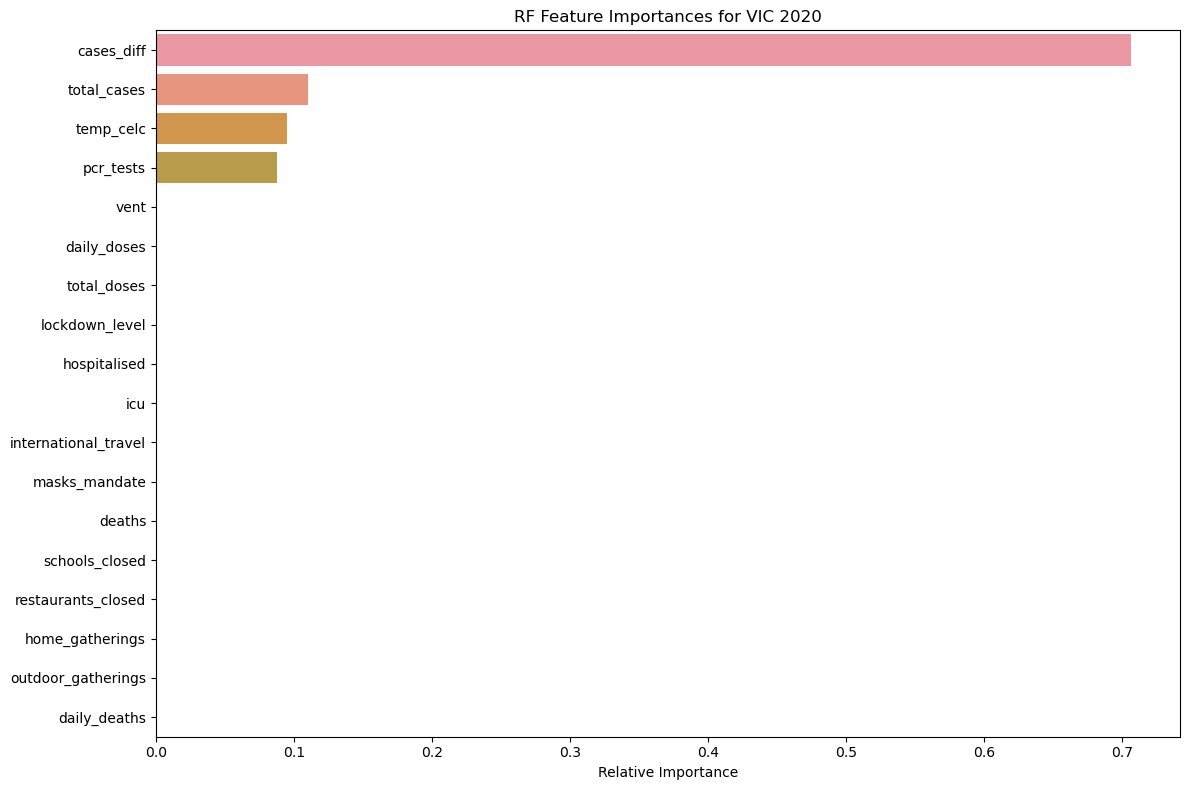

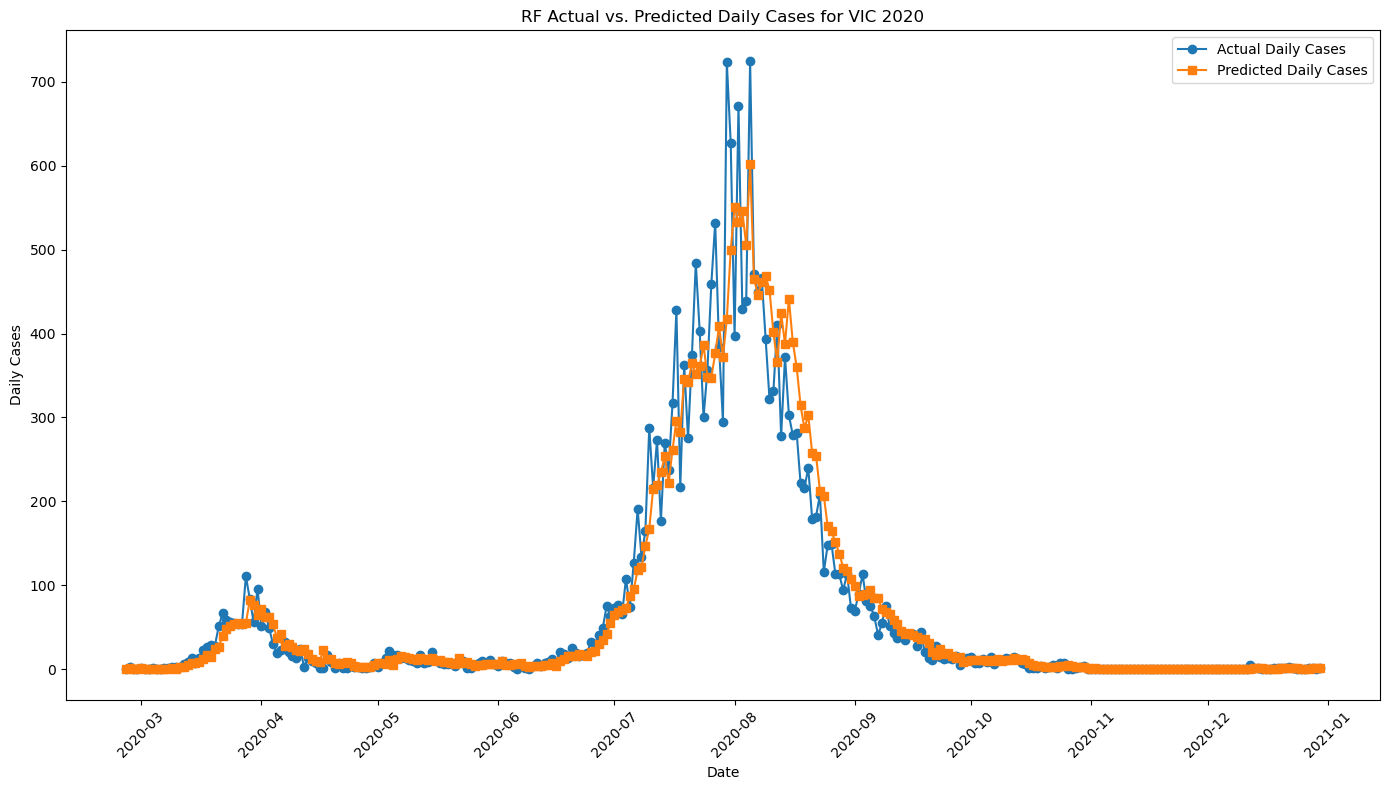

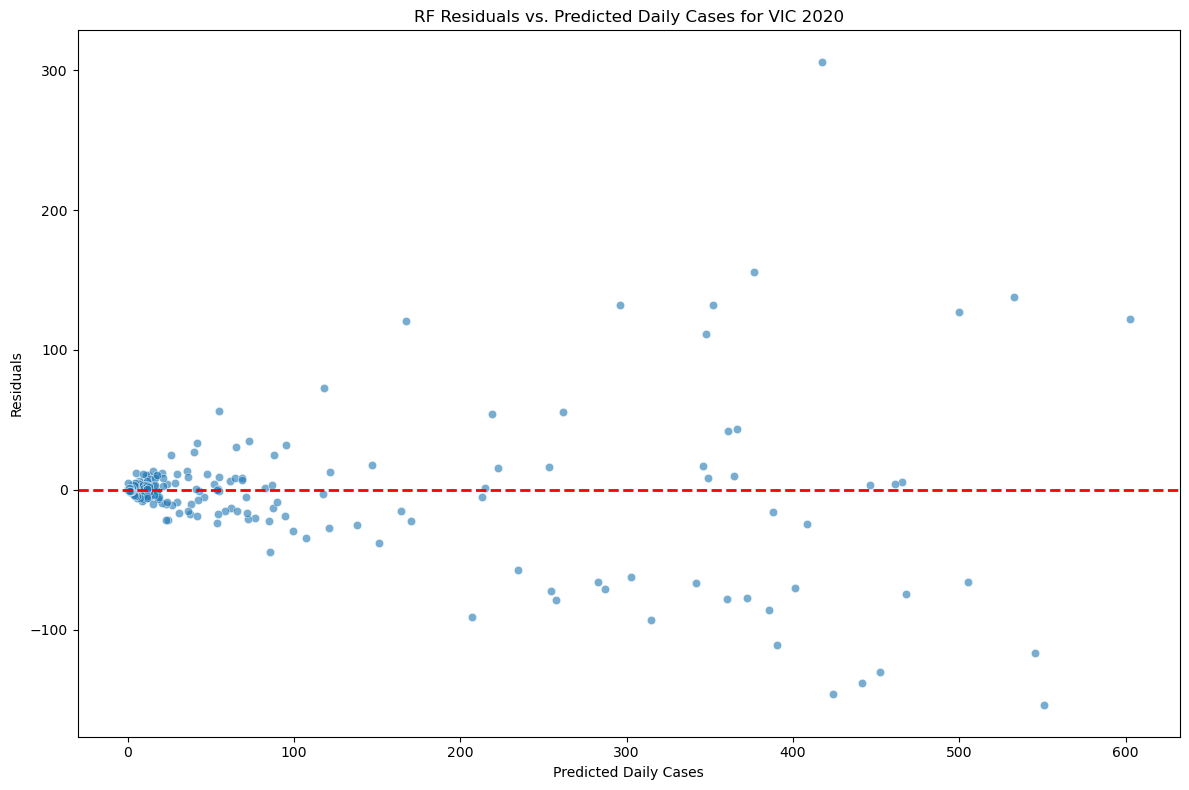

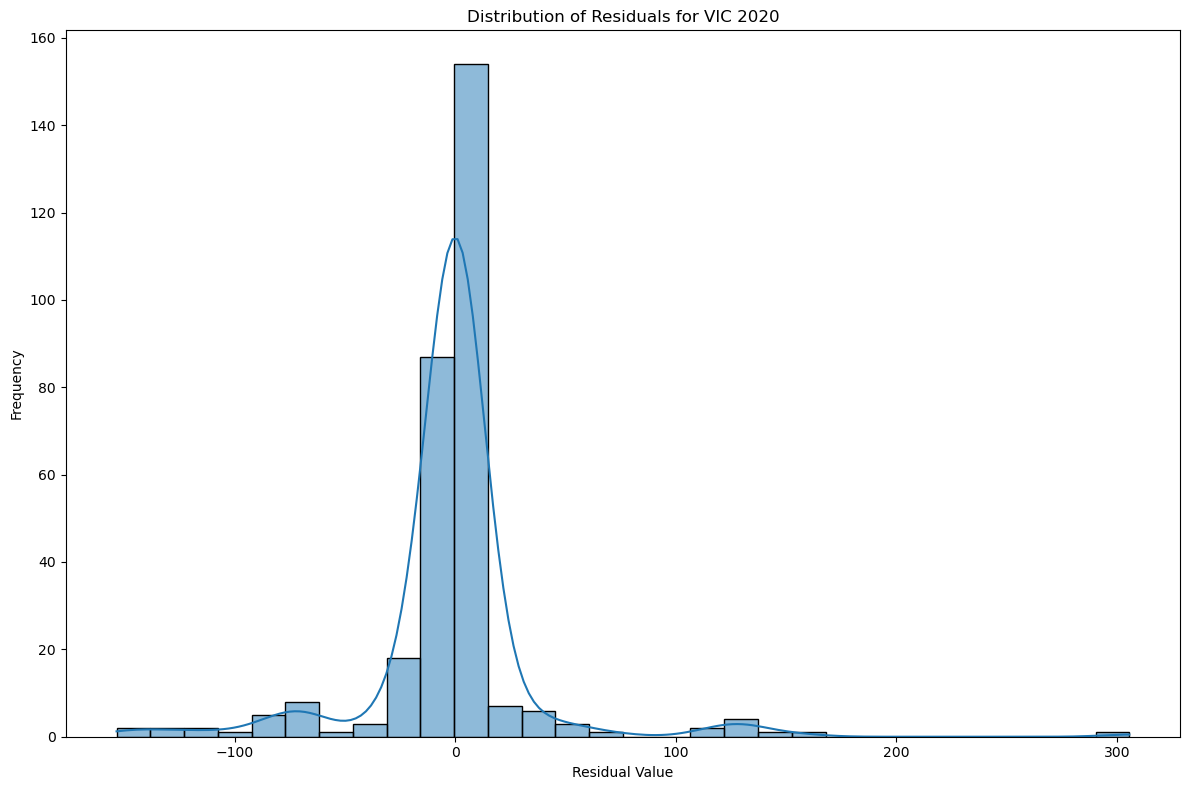

Results for year: 2021
MSE: 32018.308196107784
RMSE: 178.93660384646788
MAE: 67.51122754491018
R2 Score: 0.9390958033660681
Average Daily Cases for 2021: 435.41
 1) total_doses                    0.202356
 2) pcr_tests                      0.200174
 3) deaths                         0.197095
 4) total_cases                    0.165323
 5) cases_diff                     0.100565
 6) daily_doses                    0.036034
 7) vent                           0.031050
 8) icu                            0.026242
 9) hospitalised                   0.023320
10) daily_deaths                   0.009631
11) temp_celc                      0.008210
12) masks_mandate                  0.000000
13) schools_closed                 0.000000
14) lockdown_level                 0.000000
15) restaurants_closed             0.000000
16) home_gatherings                0.000000
17) outdoor_gatherings             0.000000
18) international_travel           0.000000


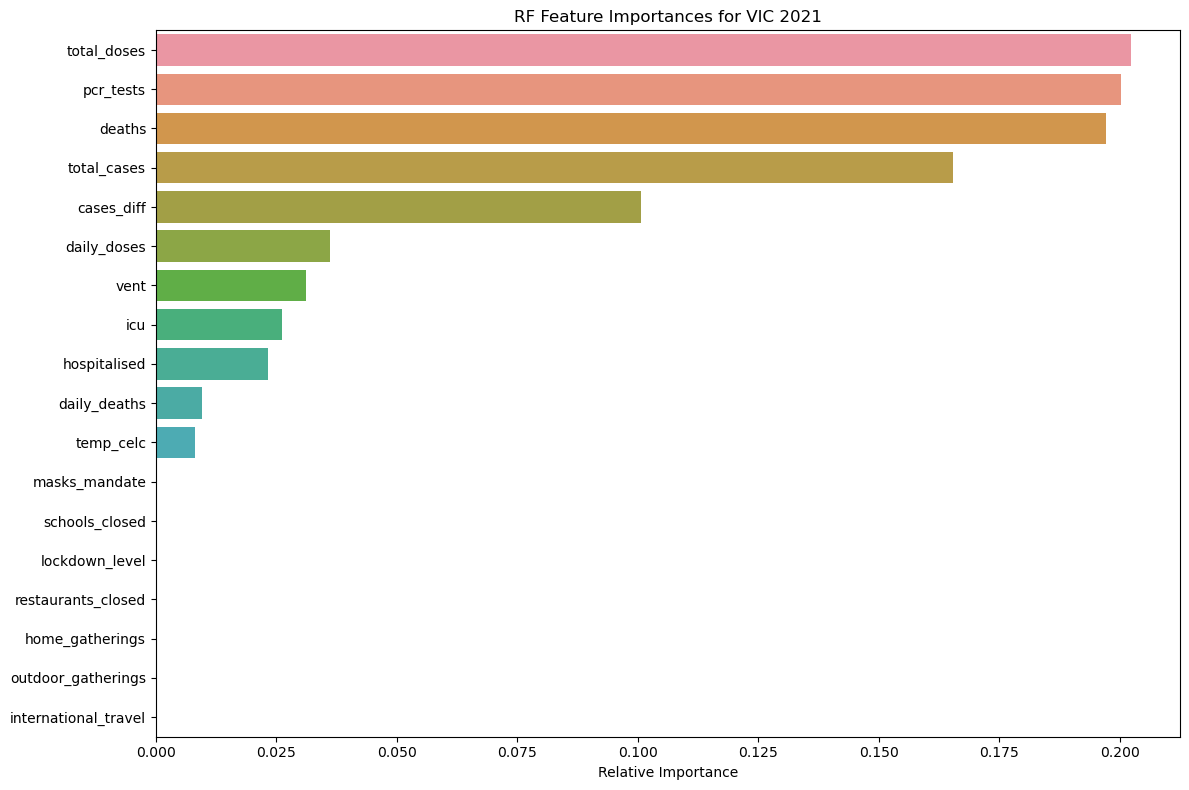

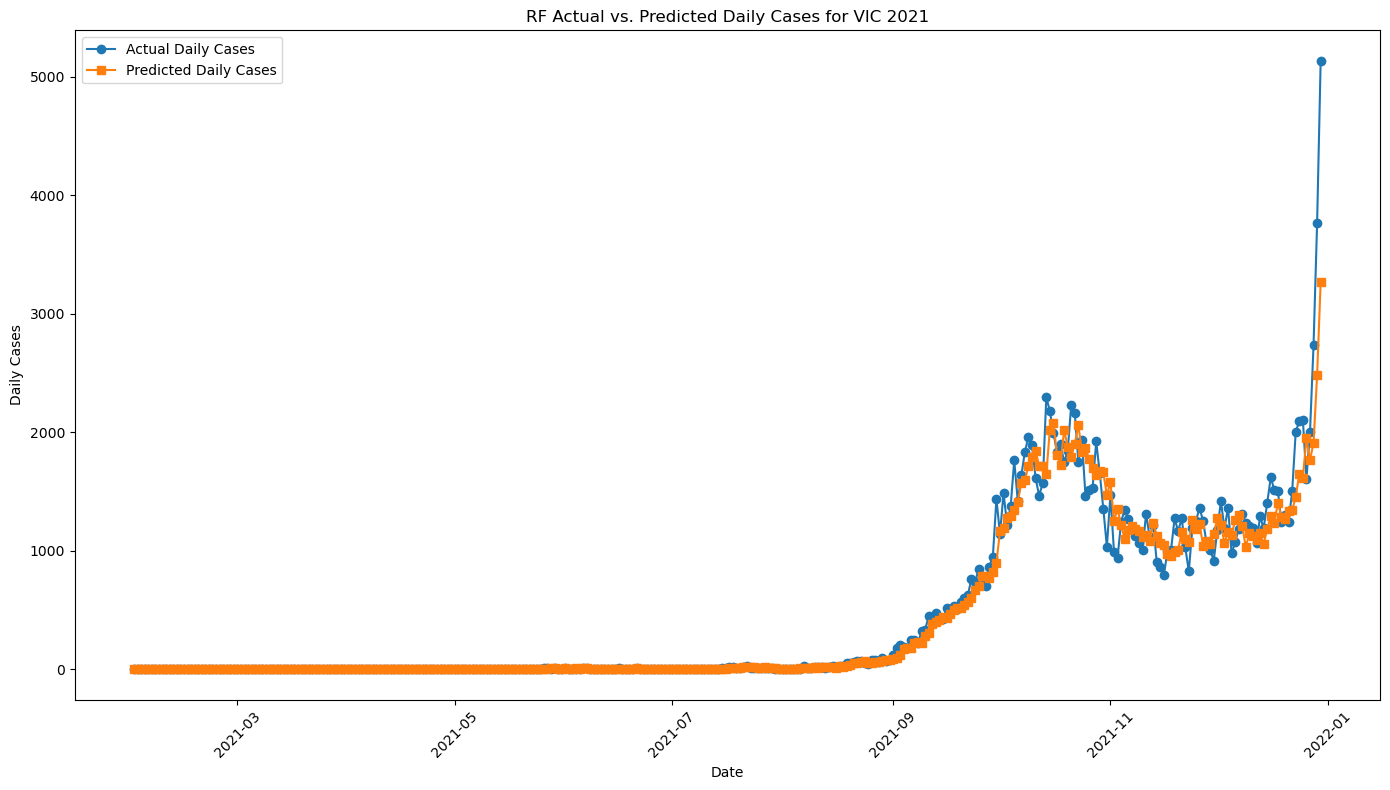

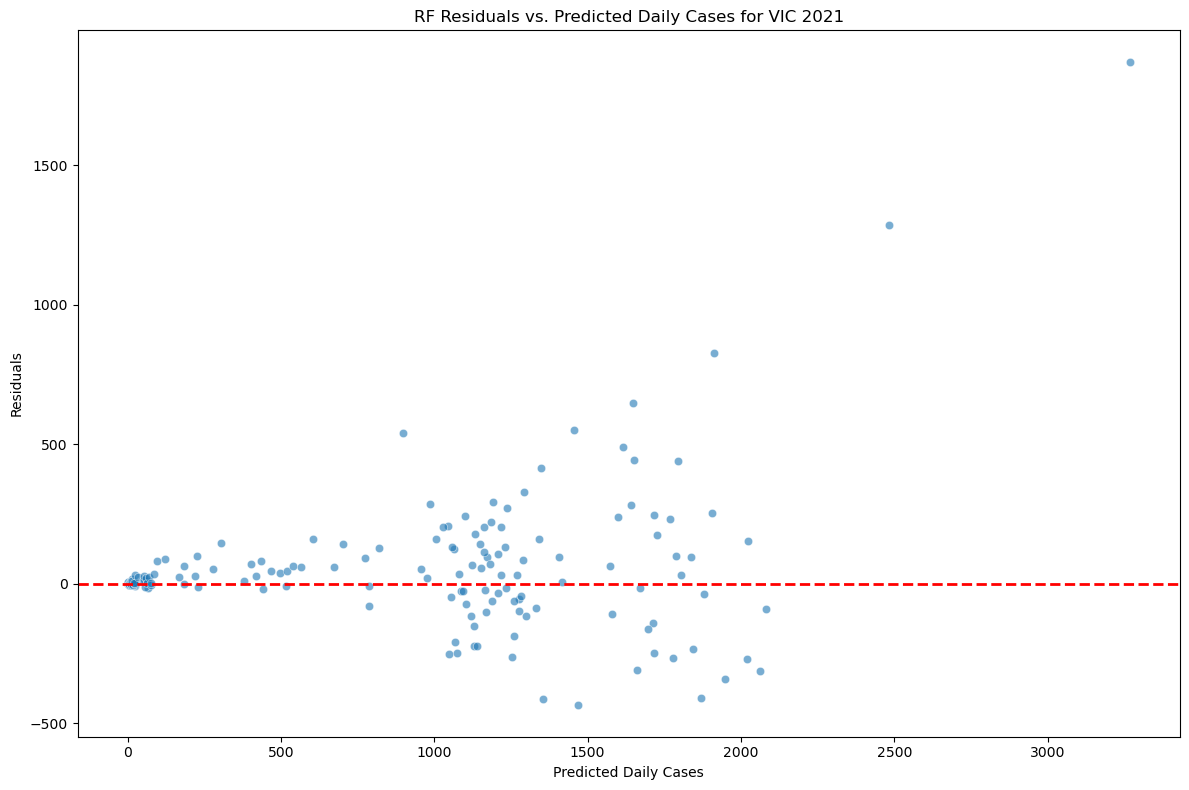

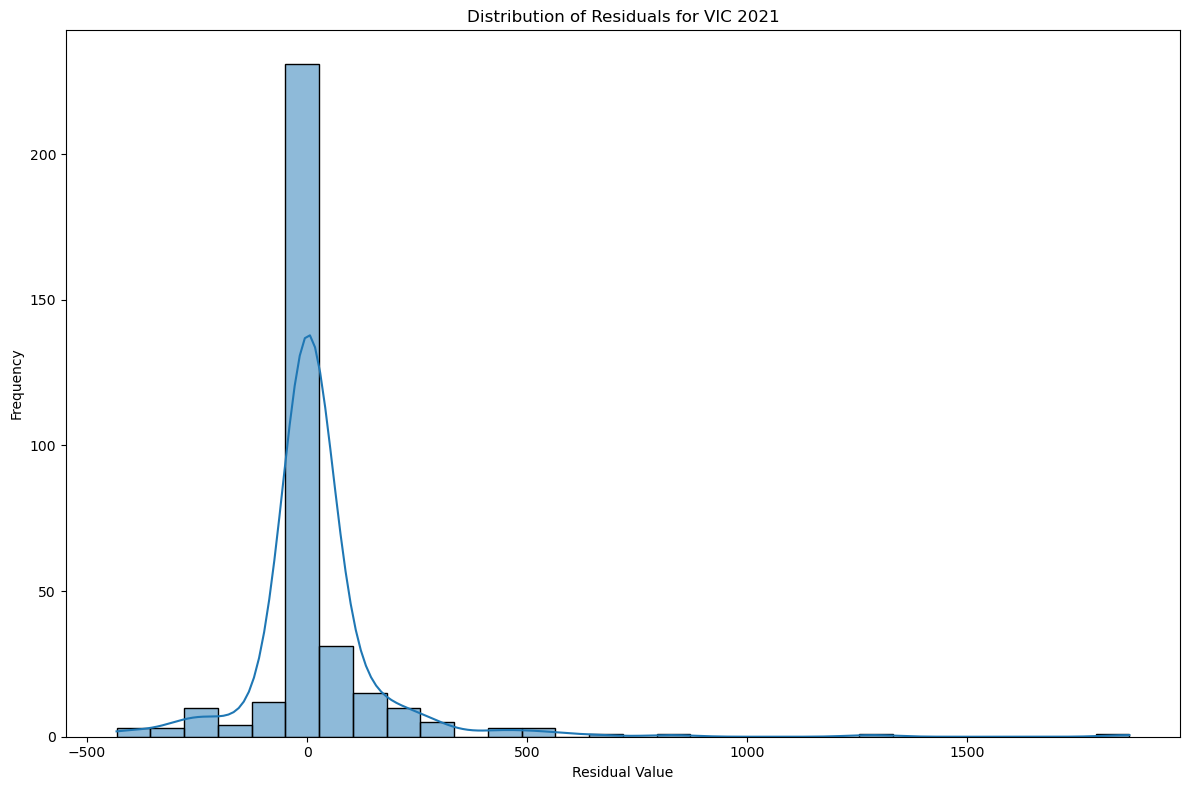

Results for year: 2022
MSE: 1433792.4257660634
RMSE: 1197.410717242026
MAE: 933.1282805429864
R2 Score: 0.8300850674538957
Average Daily Cases for 2022: 9840.10
 1) pcr_tests                      0.214965
 2) hospitalised                   0.204184
 3) deaths                         0.180858
 4) total_cases                    0.175399
 5) daily_doses                    0.061670
 6) total_doses                    0.055357
 7) daily_deaths                   0.042459
 8) icu                            0.024423
 9) temp_celc                      0.017416
10) cases_diff                     0.014813
11) vent                           0.008455
12) masks_mandate                  0.000000
13) schools_closed                 0.000000
14) lockdown_level                 0.000000
15) restaurants_closed             0.000000
16) home_gatherings                0.000000
17) outdoor_gatherings             0.000000
18) international_travel           0.000000


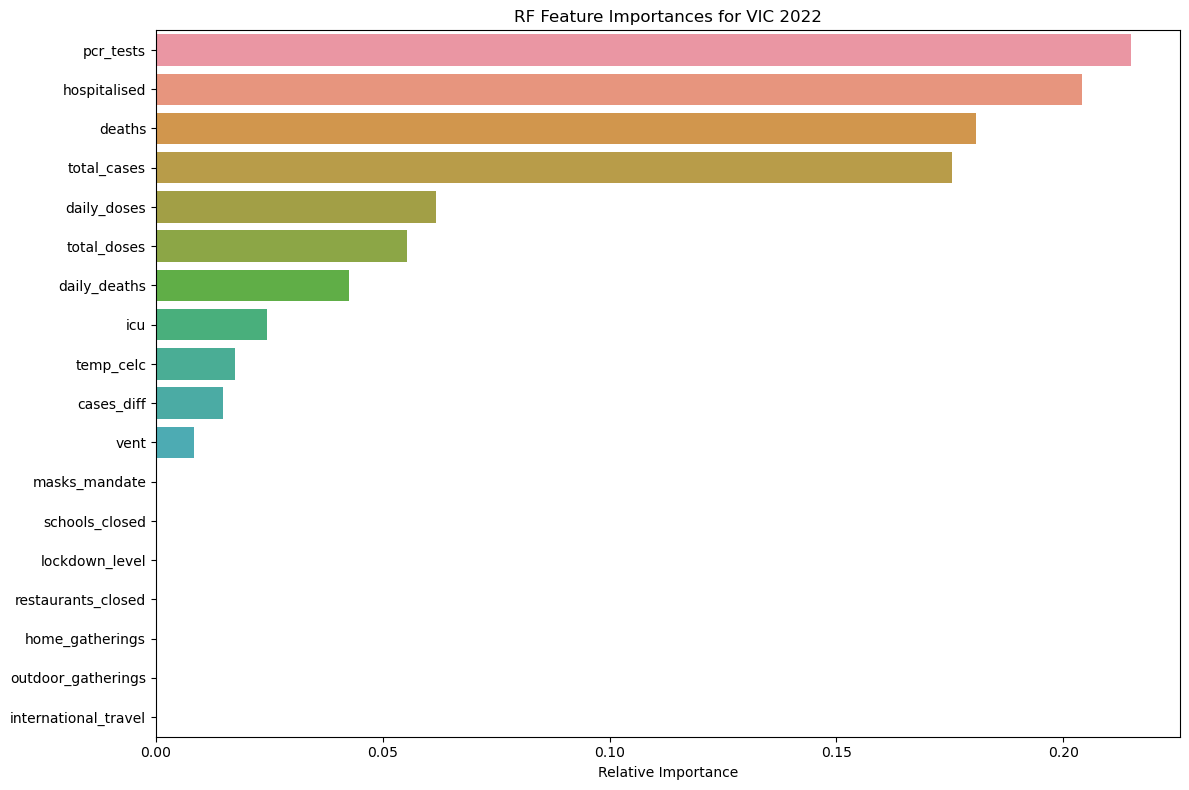

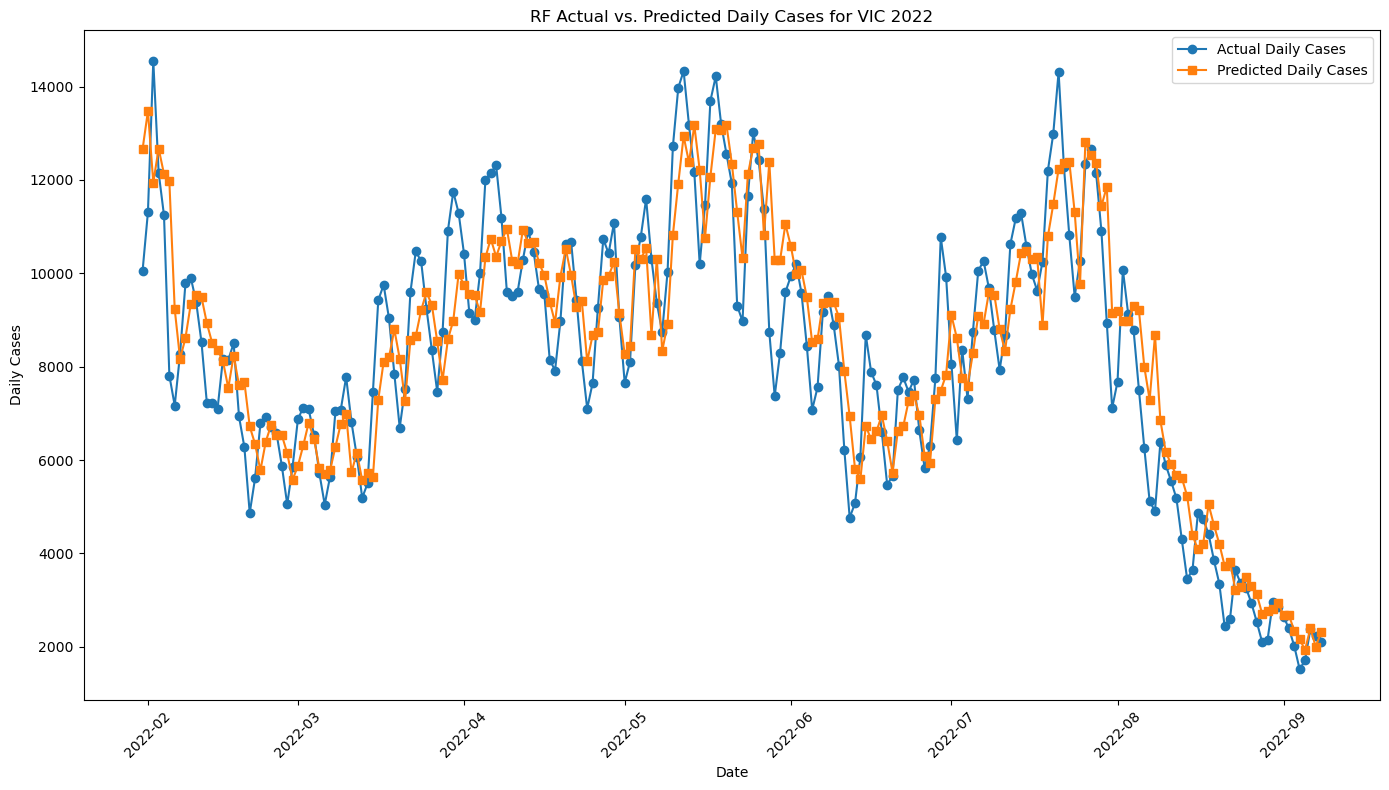

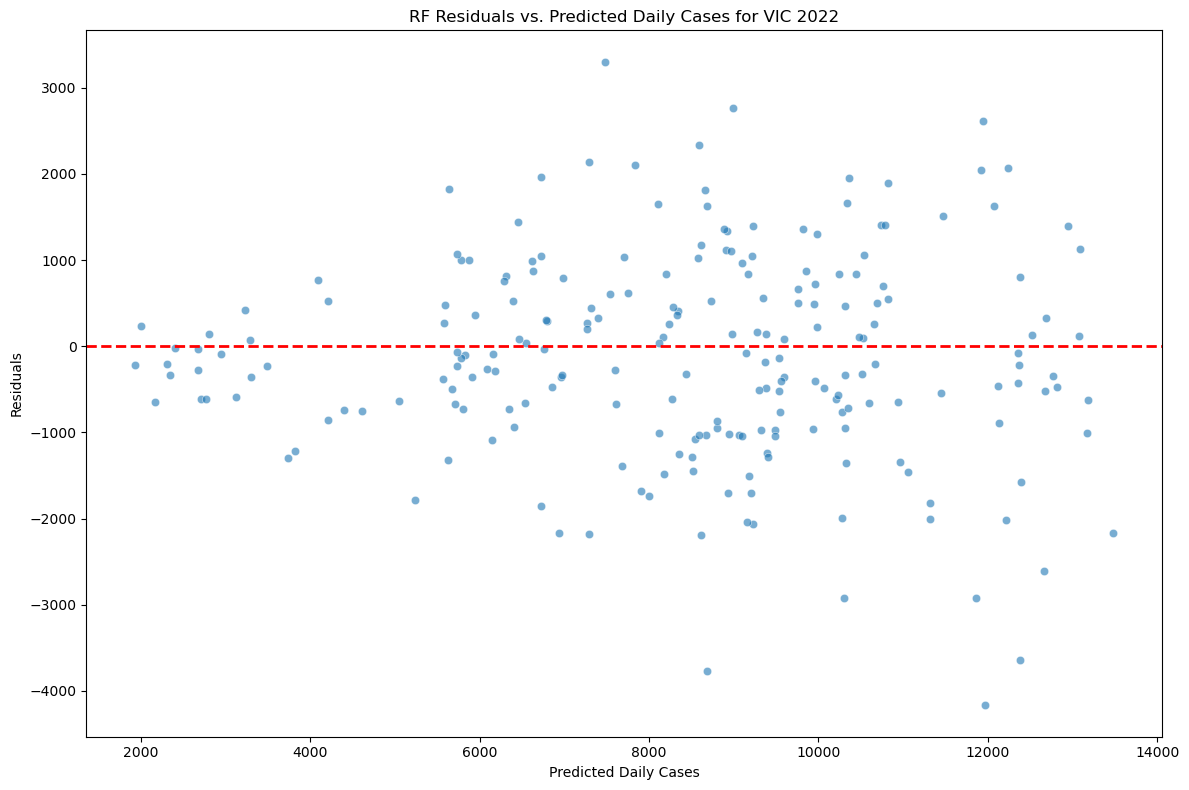

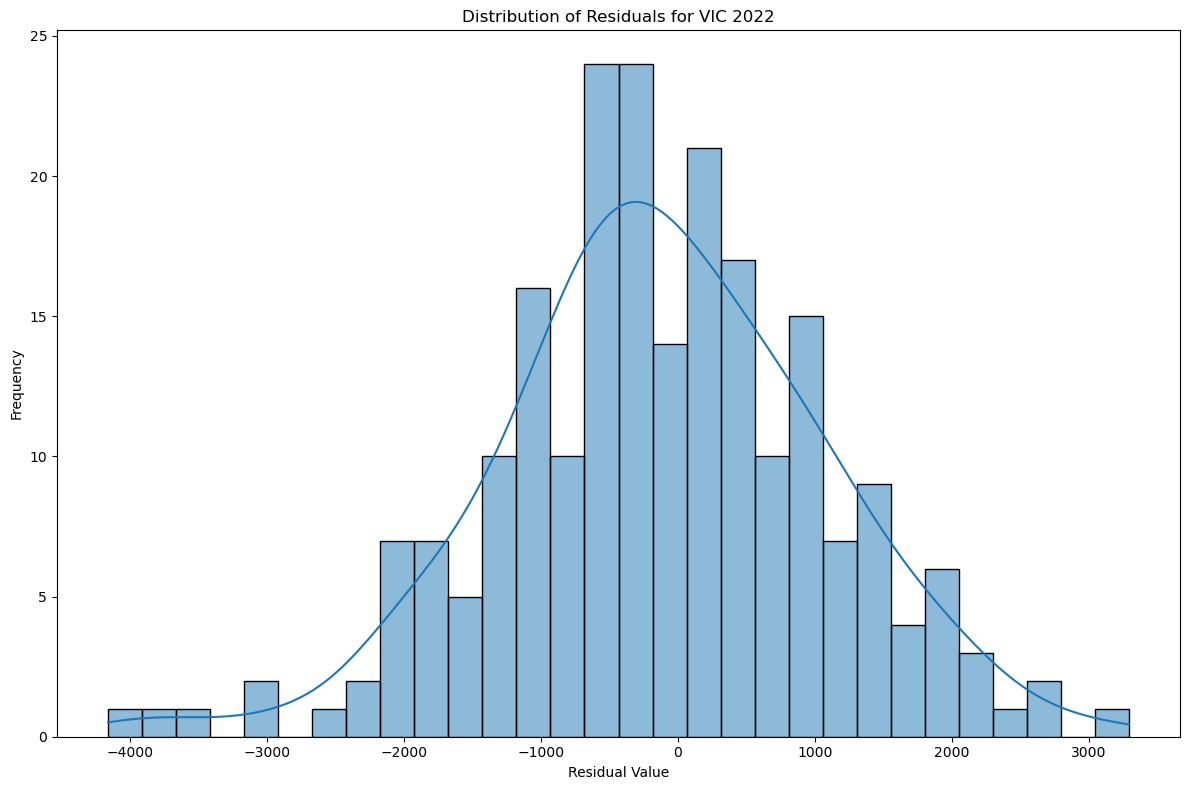

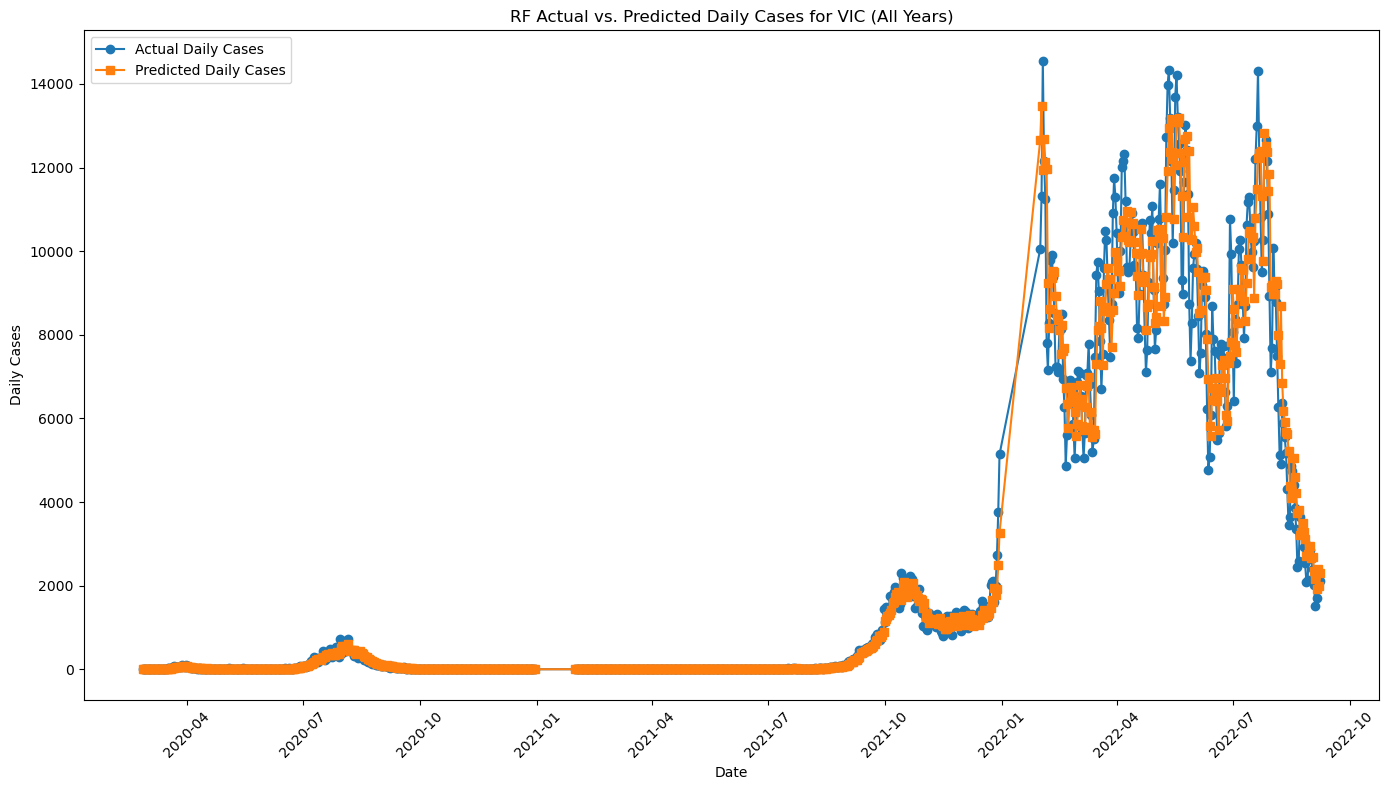

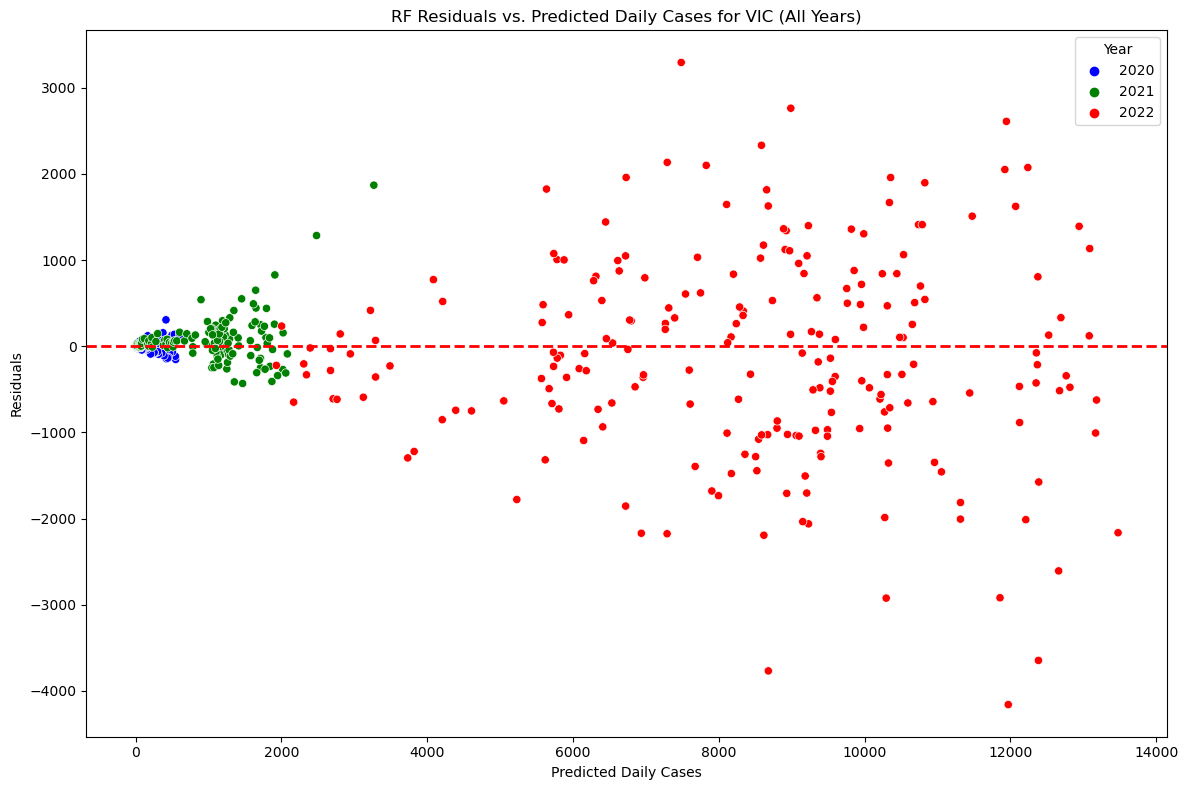

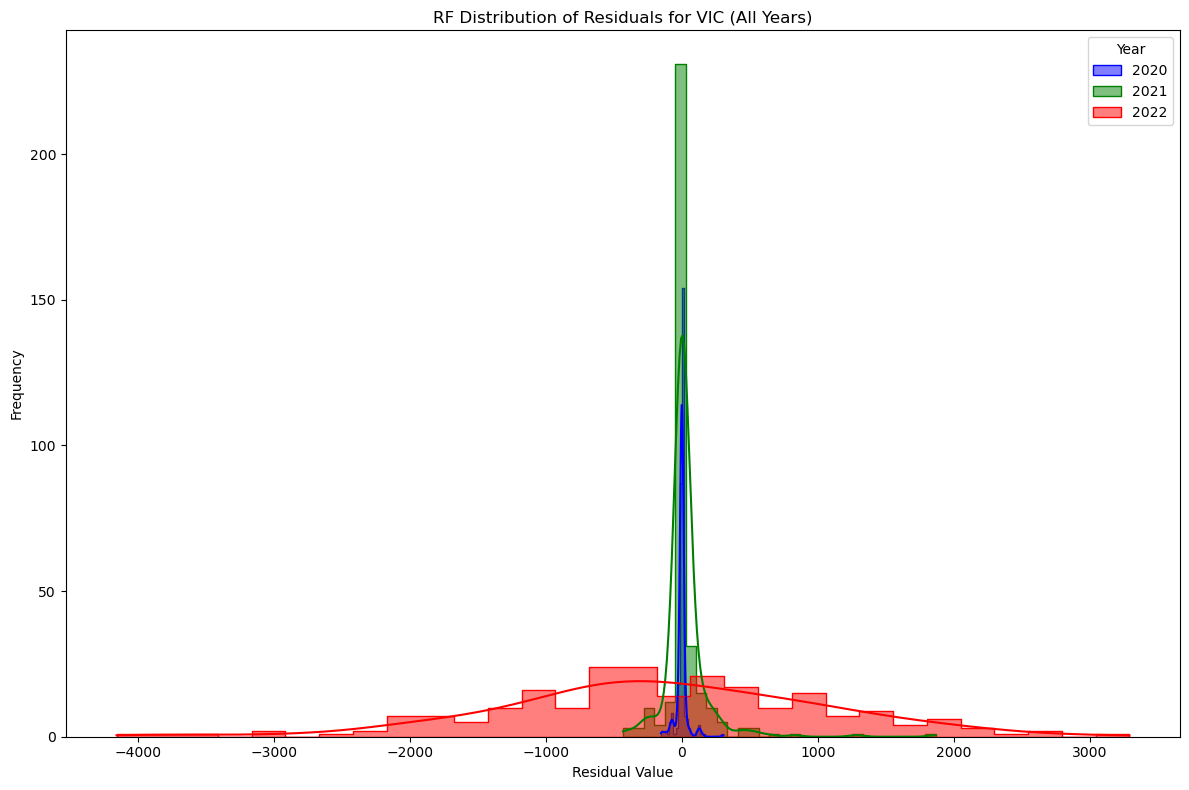

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load Data
df = pd.read_csv("vicdata.csv")

# Convert date format for model
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by='date')

# Define features
features = [
    "cases_diff", "total_cases", "daily_doses", "total_doses", "lockdown_level",
    "hospitalised", "icu", "vent", "daily_deaths", "deaths", "pcr_tests", "temp_celc",
    "schools_closed", "restaurants_closed", "home_gatherings", "outdoor_gatherings",
    "masks_mandate", "international_travel"
]

# Create arrays to store results for all years
all_y_test = []
all_y_pred = []
all_years = []
all_test_dates = []

# Set window size to 30 
window_size = 30

for year in [2020, 2021, 2022]:
    print(f"Results for year: {year}")
    df_year = df[df['date'].dt.year == year]

    X = df_year[features]
    y = df_year["daily_cases"]

    yearly_y_test = []
    yearly_y_pred = []

    # Sliding Window Loop
    for start in range(0, len(df_year) - window_size - 1):
        train = df_year[start:start + window_size]
        test = df_year[start + window_size:start + window_size + 1]
        
        X_train = train[features]
        y_train = train["daily_cases"]
        
        X_test = test[features]
        y_test = test["daily_cases"]
        
        test_date = test['date'].values[0]
        all_test_dates.append(test_date)

        # Train 
        forest = RandomForestRegressor(n_estimators=100, random_state=42)
        forest.fit(X_train, y_train)

        # Predict
        y_pred = forest.predict(X_test)

        yearly_y_test.append(y_test.values[0])
        yearly_y_pred.append(y_pred[0])

    # Add results for the current year to the total results
    all_y_test.extend(yearly_y_test)
    all_y_pred.extend(yearly_y_pred)
    all_years.append(year)

    mse = mean_squared_error(yearly_y_test, yearly_y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(yearly_y_test, yearly_y_pred)
    r2 = r2_score(yearly_y_test, yearly_y_pred)
    avg_daily_cases = df_year["daily_cases"].mean()

    print("MSE:", mse)
    print("RMSE:", rmse)
    print("MAE:", mae)
    print("R2 Score:", r2)
    print(f"Average Daily Cases for {year}: {avg_daily_cases:.2f}")

    # Feature Importances
    importances = forest.feature_importances_
    indices = np.argsort(importances)[::-1]
    for f in range(X_train.shape[1]):
        print("%2d) %-*s %f" % (f + 1, 30, features[indices[f]], importances[indices[f]]))

    # Feature Importance Plot
    plt.figure(figsize=(12, 8))
    sns.barplot(x=importances[indices], y=np.array(features)[indices])
    plt.title(f'RF Feature Importances for VIC {year}')
    plt.xlabel('Relative Importance')
    plt.tight_layout()
    plt.show()

    # Actual vs. Predicted Daily Cases Plot
    plt.figure(figsize=(14, 8))
    test_dates = df_year['date'][window_size:window_size+len(yearly_y_pred)]
    plt.plot(test_dates, yearly_y_test, 'o-', label='Actual Daily Cases')
    plt.plot(test_dates, yearly_y_pred, 's-', label='Predicted Daily Cases')
    plt.title(f'RF Actual vs. Predicted Daily Cases for VIC {year}')
    plt.xlabel('Date')
    plt.ylabel('Daily Cases')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Residuals vs. Predicted Scatter Plot
    residuals = np.array(yearly_y_test) - np.array(yearly_y_pred)
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x=yearly_y_pred, y=residuals, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--', lw=2)
    plt.xlabel('Predicted Daily Cases')
    plt.ylabel('Residuals')
    plt.title(f'RF Residuals vs. Predicted Daily Cases for VIC {year}')
    plt.tight_layout()
    plt.show()

    # Distribution of Residuals Histogram
    plt.figure(figsize=(12, 8))
    sns.histplot(residuals, kde=True, bins=30)
    plt.title(f'Distribution of Residuals for VIC {year}')
    plt.xlabel('Residual Value')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

# Actual vs. Predicted Daily Cases for All Years 
plt.figure(figsize=(14, 8))
plt.plot(all_test_dates, all_y_test, 'o-', label='Actual Daily Cases')
plt.plot(all_test_dates, all_y_pred, 's-', label='Predicted Daily Cases')
plt.title('RF Actual vs. Predicted Daily Cases for VIC (All Years)')
plt.xlabel('Date')
plt.ylabel('Daily Cases')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Residuals for All Years Scatter Plot
plt.figure(figsize=(12, 8))
sort_indices = np.argsort(all_test_dates)
all_test_dates = np.array(all_test_dates)[sort_indices]
all_y_test = np.array(all_y_test)[sort_indices]
all_y_pred = np.array(all_y_pred)[sort_indices]
residuals_all = all_y_test - all_y_pred
palette = {"2020": 'blue', "2021": 'green', "2022": 'red'} 
sns.scatterplot(x=all_y_pred, 
                y=residuals_all, 
                hue=pd.to_datetime(all_test_dates).year.astype(str), 
                palette=palette,  
                legend="full")
plt.axhline(0, color='red', linestyle='--', lw=2)
plt.xlabel('Predicted Daily Cases')
plt.ylabel('Residuals')
plt.title('RF Residuals vs. Predicted Daily Cases for VIC (All Years)')
plt.legend(title="Year")
plt.tight_layout()
plt.show()

# Distribution of Residuals for All Years
plt.figure(figsize=(12, 8))
residuals_df = pd.DataFrame({
    'Residuals': all_y_test - all_y_pred,
    'Year': pd.to_datetime(all_test_dates).year.astype(str) 
})
palette = {"2020": 'blue', "2021": 'green', "2022": 'red'}
for year, color in palette.items():
    sns.histplot(data=residuals_df[residuals_df['Year'] == year], 
                 x='Residuals', 
                 kde=True, 
                 color=color, 
                 element="step", 
                 bins=30, 
                 common_norm=False,  
                 label=f'{year}') 
plt.title('RF Distribution of Residuals for VIC (All Years)')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.legend(title='Year') 
plt.tight_layout()
plt.show()

